In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from pandasql import sqldf
import sqlite3
import math as m
import matplotlib.ticker as mtick
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 100)

**Syncing lin data with gyro data (join order) **

In [18]:
db_path = '/Users/tokihossoin/PythonDataAnalysisPrayerAssitApp/Database/paDB_20.12.23'

# connecting to db
conn = sqlite3.connect(db_path)
# Relevant tables inside db
TABLE_USER = "dim_user"
TABLE_GYRO = "gyroscope"
TABLE_LINACC = "linear_acceleration" 


# Syncing gyro and lin acc as they were collected at the same time
lin_gyro_data = f"""
WITH
lin_acc AS (
  SELECT 
  	*,
  --should be called unique_join_order really
		RANK() OVER(PARTITION BY user_id,prayer_id ORDER BY event_time) AS join_order
  FROM linear_acceleration
)

, gyro AS (
  SELECT 
  	*,
  	RANK() OVER(PARTITION BY user_id,prayer_id ORDER BY event_time) AS join_order
  FROM gyroscope
)

, lin_gyro_sync AS (
SELECT
a.user_id,
LOWER(name) as name,
height,
a.prayer_id,
a.event_time,
a.join_order, --ordered by event_time and paritioned by prayer id
x_gyro,
y_gyro,
z_gyro,
x_linacc,
y_linacc,
z_linacc,
a.motion,
a.placement,
a.side,
a.elevation

FROM lin_acc a
LEFT JOIN gyro b
	ON a.join_order = b.join_order
  AND a.prayer_id = b.prayer_id
  AND a.user_id = b.user_id
JOIN dim_user c
	ON a.user_id = c.user_id

WHERE TRUE
	AND x_gyro IS NOT NULL
  AND y_gyro IS NOT NULL
  AND z_gyro IS NOT NULL
)

--sanity check before downloading data
-- SELECT
-- name,
-- COUNT(distinct prayer_id) AS num_prayer_ids
-- FROM lin_gyro_sync
-- GROUP BY 1

--download data
SELECT * FROM lin_gyro_sync
"""
lin_gyro_df = pd.read_sql_query(lin_gyro_data,conn)
lin_gyro_df.set_index('user_id',inplace=True)
lin_gyro_df

,name,height,prayer_id,event_time,join_order,x_gyro,y_gyro,z_gyro,x_linacc,y_linacc,z_linacc,motion,placement,side,elevation
user_id,,,,,,,,,,,,,,,
5,toki,6.3,1,23-12-2023 18:23:36.551077,1,0.00,0.00,0.00,424.00,0.00,0.00,bowing,l_p2,right,up_skin
5,toki,6.3,1,23-12-2023 18:23:36.660926,2,0.00,0.00,0.00,424.00,0.00,0.00,bowing,l_p2,right,up_skin
5,toki,6.3,1,23-12-2023 18:23:36.801895,3,0.00,0.00,0.00,424.00,0.00,0.00,bowing,l_p2,right,up_skin
5,toki,6.3,1,23-12-2023 18:23:36.936482,4,0.00,0.00,0.00,423.00,0.00,0.00,bowing,l_p2,right,up_skin
5,toki,6.3,1,23-12-2023 18:23:37.078426,5,0.00,0.00,0.00,422.00,0.00,0.00,bowing,l_p2,right,up_skin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,aklima,5.5,2,28-12-2023 22:01:42.885439,5196,-0.60,-0.56,-0.22,-1.01,-1.20,0.29,prostrating,semi_trouser,left,down_skin
6,aklima,5.5,2,28-12-2023 22:01:42.904587,5197,-0.36,-0.22,-0.03,-0.61,-0.36,0.28,prostrating,semi_trouser,left,down_skin
6,aklima,5.5,2,28-12-2023 22:01:42.930232,5198,0.30,-0.35,0.03,-0.05,0.26,-0.69,prostrating,semi_trouser,left,down_skin


**Distinct user data**

In [19]:
users_data = """
SELECT 
    DISTINCT
    user_id,
    name,
    height
FROM lin_gyro_df
"""
users = sqldf(users_data, globals())
users.set_index(['user_id'], inplace=True)

users

,name,height
user_id,,
5,toki,6.3
6,aklima,5.5


In [25]:
userid = 6

## remove noise
initial_noise = 350
finish_noise = 500

## keep noise
# initial_noise = 0
# finish_noise = 0

## Name and Height of user data analysed
name = users.loc[userid,'name']
height = users.loc[userid,'height']

**All user data query**

In [26]:
standing_data =f"""
SELECT
    user_id,
    prayer_id,
    height,
    join_order,
    x_gyro,
    y_gyro,
    z_gyro,
    x_linacc,
    y_linacc,
    z_linacc,
    motion,
    placement,
    side,
    elevation
    
FROM lin_gyro_df
WHERE TRUE
    AND motion = 'standing'
    --AND side = 'right'
    AND side = 'left'
    AND user_id= {userid}
    --cleaning noise (putting phone in pocket)
    AND join_order > {initial_noise}
    -- cleaning noise (taking phone out of pocket)
    AND join_order < (SELECT MAX(join_order)-{finish_noise} FROM lin_gyro_df WHERE motion = 'standing' and user_id = {userid})
"""

bowing_data =f"""
SELECT
    user_id,
    prayer_id,
    height,
    event_time,
    join_order,
    x_gyro,
    y_gyro,
    z_gyro,
    x_linacc,
    y_linacc,
    z_linacc,
    motion,
    placement,
    side,
    elevation
    
FROM lin_gyro_df
WHERE TRUE
    AND motion = 'bowing'
    -- AND side = 'right'
    AND side = 'left'
    AND user_id = {userid}
    --cleaning noise (putting phone in pocket)
    AND join_order > {initial_noise}
    -- cleaning noise (taking phone out of pocket)
    AND join_order < (SELECT MAX(join_order)-{finish_noise} FROM lin_gyro_df WHERE motion = 'bowing' and user_id = {userid})
"""

prostrating_data =f"""
SELECT
    user_id,
    prayer_id,
    height,
    join_order,
    x_gyro,
    y_gyro,
    z_gyro,
    x_linacc,
    y_linacc,
    z_linacc,
    motion,
    placement,
    side,
    elevation
    
FROM lin_gyro_df
WHERE TRUE
    AND motion = 'prostrating'
    --AND side = 'right'
    AND side = 'left'
    AND user_id= {userid}
    --cleaning noise (putting phone in pocket)
    AND join_order > {initial_noise}
    -- cleaning noise (taking phone out of pocket)
    AND join_order < (SELECT MAX(join_order)-{finish_noise} FROM lin_gyro_df WHERE motion = 'prostrating' and user_id = {userid})
"""

sitting_data =f"""
SELECT
    user_id,
    prayer_id,
    height,
    join_order,
    x_gyro,
    y_gyro,
    z_gyro,
    x_linacc,
    y_linacc,
    z_linacc,
    motion,
    placement,
    side,
    elevation
    
FROM lin_gyro_df
WHERE TRUE
    AND motion = 'sitting'
    AND side = 'right'
    -- AND side = 'left'
    AND user_id= {userid}
    --cleaning noise (putting phone in pocket)
    AND join_order > {initial_noise}
    -- cleaning noise (taking phone out of pocket)
    AND join_order < (SELECT MAX(join_order)-{finish_noise} FROM lin_gyro_df WHERE motion = 'sitting' and user_id = {userid})
"""


prostrating = sqldf(prostrating_data, globals())
bowing = sqldf(bowing_data, globals())
standing = sqldf(standing_data, globals())
sitting= sqldf(sitting_data, globals())



**All motion data**

In [27]:
# prostrating
bowing
# standing
# sitting

,user_id,prayer_id,height,event_time,join_order,x_gyro,y_gyro,z_gyro,x_linacc,y_linacc,z_linacc,motion,placement,side,elevation
0,6,1,5.5,28-12-2023 21:56:23.115376,351,-0.03,0.07,0.01,-0.30,-0.01,-0.11,bowing,semi_trouser,left,down_skin
1,6,1,5.5,28-12-2023 21:56:23.138462,352,-0.01,0.03,0.01,-0.06,0.02,-0.02,bowing,semi_trouser,left,down_skin
2,6,1,5.5,28-12-2023 21:56:23.154150,353,0.01,0.04,0.01,0.28,0.01,0.09,bowing,semi_trouser,left,down_skin
3,6,1,5.5,28-12-2023 21:56:23.177560,354,-0.03,0.02,0.05,0.52,-0.06,-0.03,bowing,semi_trouser,left,down_skin
4,6,1,5.5,28-12-2023 21:56:23.200906,355,-0.04,0.03,0.09,0.42,0.05,-0.10,bowing,semi_trouser,left,down_skin
5,6,1,5.5,28-12-2023 21:56:23.215816,356,-0.04,0.08,0.09,0.13,0.06,0.04,bowing,semi_trouser,left,down_skin
6,6,1,5.5,28-12-2023 21:56:23.238105,357,-0.05,0.16,0.07,-0.25,0.08,0.08,bowing,semi_trouser,left,down_skin
7,6,1,5.5,28-12-2023 21:56:23.258154,358,-0.08,0.24,0.03,-0.59,-0.03,0.05,bowing,semi_trouser,left,down_skin
8,6,1,5.5,28-12-2023 21:56:23.284217,359,-0.08,0.27,-0.01,-0.70,-0.09,0.12,bowing,semi_trouser,left,down_skin
9,6,1,5.5,28-12-2023 21:56:23.299804,360,-0.07,0.29,-0.05,-0.68,-0.08,0.22,bowing,semi_trouser,left,down_skin


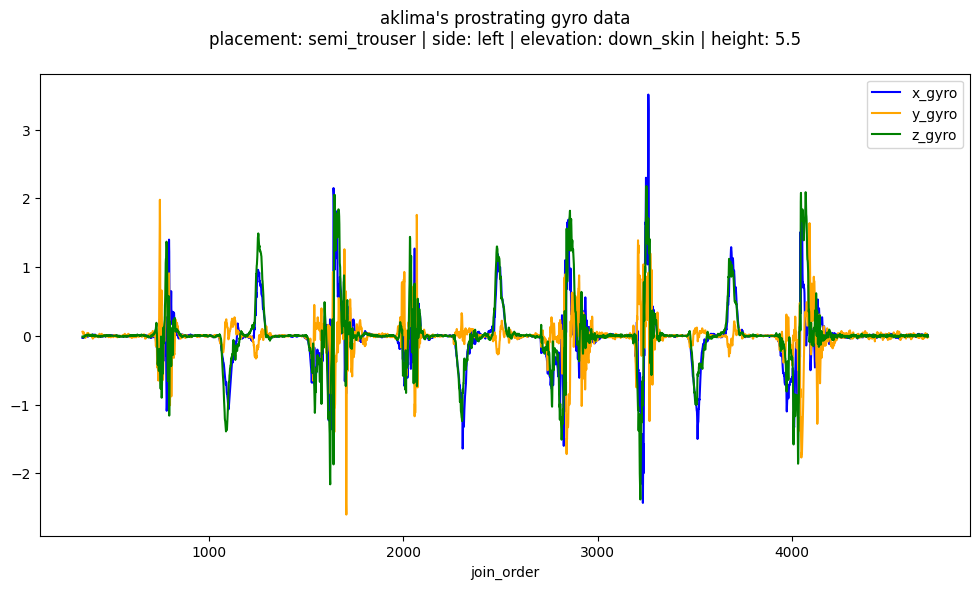

In [35]:
## Graph settings for Gyroscope
fig = plt.figure(figsize=(12, 6))
axes = plt.gca()

## standing data
# plt.title(
# f"""{name}'s {standing.loc[0,'motion']} gyro data
# placement: {standing.loc[0,'placement']} | side: {standing.loc[0,'side']} | elevation: {standing.loc[0,'elevation']} | height: {height}
# """)
# standing.plot(kind='line', x='join_order', y='x_gyro', color = 'blue',ax=axes);
# standing.plot(kind='line', x='join_order', y='y_gyro', color = 'orange', ax=axes);
# standing.plot(kind='line', x='join_order', y='z_gyro', color = 'green',ax=axes);

## bowing data
# plt.title(
# f"""{name}'s {bowing.loc[0,'motion']} gyro data
# placement: {bowing.loc[0,'placement']} | side: {bowing.loc[0,'side']} | elevation: {bowing.loc[0,'elevation']} | height: {height}
# """)
# bowing.plot(kind='line', x='join_order', y='x_gyro', color = 'blue',ax=axes);
# bowing.plot(kind='line', x='join_order', y='y_gyro', color = 'orange', ax=axes);
# bowing.plot(kind='line', x='join_order', y='z_gyro', color = 'green',ax=axes);

# prostrating data
plt.title(
f"""{name}'s {prostrating.loc[0,'motion']} gyro data
placement: {prostrating.loc[0,'placement']} | side: {prostrating.loc[0,'side']} | elevation: {prostrating.loc[0,'elevation']} | height: {height}
""")
prostrating.plot(kind='line', x='join_order', y='x_gyro', color = 'blue',ax=axes);
prostrating.plot(kind='line', x='join_order', y='y_gyro', color = 'orange', ax=axes);
prostrating.plot(kind='line', x='join_order', y='z_gyro', color = 'green',ax=axes);

## sitting data
# plt.title(
# f"""{name}'s {sitting.loc[0,'motion']} gyro data
# placement: {sitting.loc[0,'placement']} | side: {sitting.loc[0,'side']} | elevation: {sitting.loc[0,'elevation']} | height: {height}
# """)
# sitting.plot(kind='line', x='join_order', y='x_gyro', color = 'blue',ax=axes);
# sitting.plot(kind='line', x='join_order', y='y_gyro', color = 'orange', ax=axes);
# sitting.plot(kind='line', x='join_order', y='z_gyro', color = 'green',ax=axes);

# plt.show()
plt.savefig('/Users/tokihossoin/PythonDataAnalysisPrayerAssitApp/Images/images',dpi=200,bbox_inches ='tight')


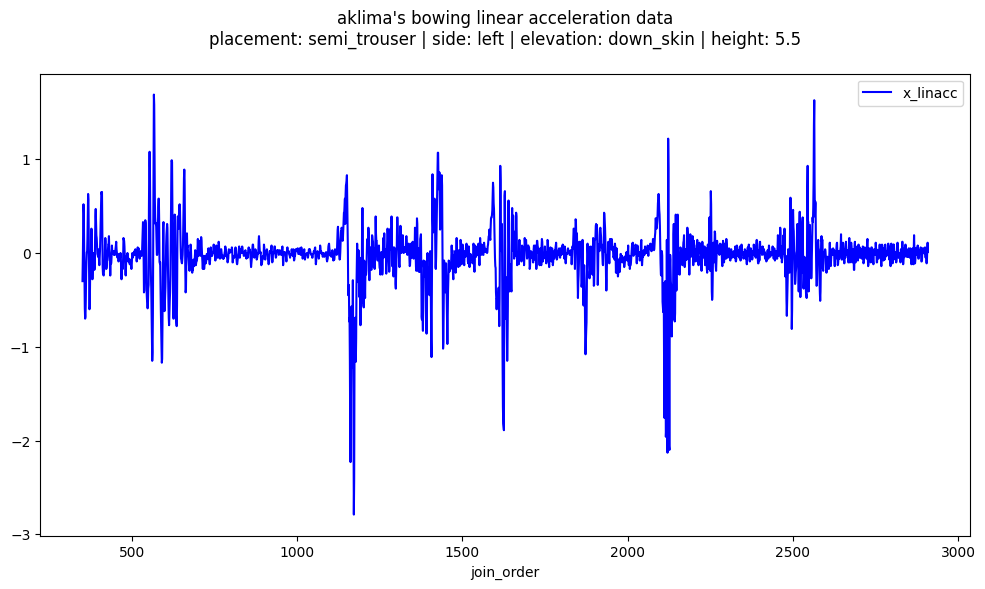

In [31]:
## Graph settings for linear acceleration
fig = plt.figure(figsize=(12, 6))
axes = plt.gca()

# standing lin acc
# plt.title(
# f"""{name}'s {standing.loc[0,'motion']} linear acceleration data
# placement: {standing.loc[0,'placement']} | side: {standing.loc[0,'side']} | elevation: {standing.loc[0,'elevation']} | height: {height}
# """)
# standing.plot(kind='line', x='join_order', y='x_linacc',color = 'blue', ax=axes);
# standing.plot(kind='line', x='join_order', y='y_linacc',color = 'orange', ax=axes);
# standing.plot(kind='line', x='join_order', y='z_linacc',color = 'green', ax=axes);

# bowing lin acc
plt.title(
f"""{name}'s {bowing.loc[0,'motion']} linear acceleration data
placement: {bowing.loc[0,'placement']} | side: {bowing.loc[0,'side']} | elevation: {bowing.loc[0,'elevation']} | height: {height}
""")
bowing.plot(kind='line', x='join_order', y='x_linacc',color = 'blue', ax=axes);
# bowing.plot(kind='line', x='join_order', y='y_linacc',color = 'orange', ax=axes);
# bowing.plot(kind='line', x='join_order', y='z_linacc',color = 'green', ax=axes);

# prostrating lin acc
# plt.title(
# f"""{name}'s {prostrating.loc[0,'motion']} linear acceleration data
# placement: {prostrating.loc[0,'placement']} | side: {prostrating.loc[0,'side']} | elevation: {prostrating.loc[0,'elevation']} | height: {height}
# """)
# prostrating.plot(kind='line', x='join_order', y='x_linacc',color = 'blue', ax=axes);
# prostrating.plot(kind='line', x='join_order', y='y_linacc',color = 'orange', ax=axes);
# prostrating.plot(kind='line', x='join_order', y='z_linacc',color = 'green', ax=axes);

# sitting lin acc
# plt.title(
# f"""{name}'s {sitting.loc[0,'motion']} linear acceleration data
# placement: {sitting.loc[0,'placement']} | side: {sitting.loc[0,'side']} | elevation: {sitting.loc[0,'elevation']} | height: {height}
# """)
# sitting.plot(kind='line', x='join_order', y='x_linacc',color = 'blue', ax=axes);
# sitting.plot(kind='line', x='join_order', y='y_linacc',color = 'orange', ax=axes);
# sitting.plot(kind='line', x='join_order', y='z_linacc',color = 'green', ax=axes);

plt.savefig('/Users/tokihossoin/PythonDataAnalysisPrayerAssitApp/Images/images',dpi=200,bbox_inches ='tight')
plt.show()

**Normal Query stuff** 

In [66]:
minimum_point =f"""
SELECT
min(y_gyro) as minimum_gyro,
max(y_gyro) as max_gyro
FROM bowing
WHERE TRUE
    AND motion = 'bowing'
    AND join_order between 700 AND 1000
"""

output = sqldf(minimum_point, globals())
output


,minimum_gyro,max_gyro
0,-0.5,0.37
